In [1]:
from characteristic_function_functions import *
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
import math
import cmath
from scipy.integrate import simpson, romb
from scipy.stats import iqr, norm, gaussian_kde
from scipy.special import erfc, wofz
import pickle
import os

In [2]:
mu_list = np.linspace(0, 8, 51)

print(mu_list)
nu = 1.2
alpha = 1 + 0.5 * 1j
kappa = 0.8
n_precision = 1000

trial_times = 10
n = 500

phi1_true_list = []
phi1_avg_gaussian_list = []
phi1_std_real_gaussian_list = []
phi1_std_imag_gaussian_list = []

diff_phi_t1_Gaussian_list = []
bd_phi_t1_Gaussian_list = []

for mu in tqdm(mu_list):

    t_unit = 1
    phi1_true = compute_perfect_phi(mu, nu, alpha, t = t_unit)
    phi1_true_list.append(phi1_true)

    phi1_gaussian_list_per_mu = []
    L_limit = find_suitable_L(mu, nu, alpha)
    X_precision = np.linspace(-L_limit, L_limit, n_precision)

    pdf = normalized_cat_state_pdf(mu, nu, alpha, X_precision)

    for _ in range(trial_times):

        X_samples = samplings_with_noisy_pdf(pdf, X_precision, n, kappa)
        W_Gaussian, bw_Gaussian = pdf_kernel_optimal_bandwidth(X_precision, X_samples)
        phi_t1_vals_gaussian, optimal_bd = compute_gaussian_phi_at_t_optimal(mu, nu, X_precision, X_samples, W_Gaussian, t = t_unit / kappa)
        phi_t1_vals_gaussian *= 1 / np.exp( - ((1 - kappa) / kappa * t_unit)**2 / 2   )

        #print(phi_t1_vals_gaussian, compute_phi_at_t(pdf, X_precision, t=t_unit * kappa) * compute_phi_at_t(norm.pdf(X_precision), X_precision, t=t_unit * (1-kappa)))

        phi1_gaussian_list_per_mu.append(phi_t1_vals_gaussian)
        if np.abs(mu - 0.8) < 1e-4:
            diff_phi_t1_Gaussian_list.append(np.abs(phi1_true - phi_t1_vals_gaussian)**2)
            bd_phi_t1_Gaussian_list.append(optimal_bd)

    phi1_avg_gaussian = np.mean(phi1_gaussian_list_per_mu, axis = 0)
    phi1_std_real_gaussian = np.std(np.array(phi1_gaussian_list_per_mu).real, axis = 0)
    phi1_std_imag_gaussian = np.std(np.array(phi1_gaussian_list_per_mu).imag, axis = 0)

    phi1_avg_gaussian_list.append(phi1_avg_gaussian)
    phi1_std_real_gaussian_list.append(phi1_std_real_gaussian)
    phi1_std_imag_gaussian_list.append(phi1_std_imag_gaussian)


avg_error = np.mean(diff_phi_t1_Gaussian_list)
std_error = np.std(diff_phi_t1_Gaussian_list)
avg_bd = np.mean(bd_phi_t1_Gaussian_list)
std_bd = np.std(bd_phi_t1_Gaussian_list)

phi1_true_list = np.array(phi1_true_list)
phi1_avg_gaussian_list = np.array(phi1_avg_gaussian_list)
phi1_std_real_gaussian_list = np.array(phi1_std_real_gaussian_list)   
phi1_std_imag_gaussian_list = np.array(phi1_std_imag_gaussian_list)    

[0.   0.16 0.32 0.48 0.64 0.8  0.96 1.12 1.28 1.44 1.6  1.76 1.92 2.08
 2.24 2.4  2.56 2.72 2.88 3.04 3.2  3.36 3.52 3.68 3.84 4.   4.16 4.32
 4.48 4.64 4.8  4.96 5.12 5.28 5.44 5.6  5.76 5.92 6.08 6.24 6.4  6.56
 6.72 6.88 7.04 7.2  7.36 7.52 7.68 7.84 8.  ]


100%|██████████| 51/51 [00:02<00:00, 20.87it/s]


Average MSE of Gaussian kernel for phi(1):  0.0022243199063308773  +/-  0.0018025507946657791
Average bandwidth of Gaussian kernel for phi(1):  0.07341001356594441  +/-  0.009685485660950498


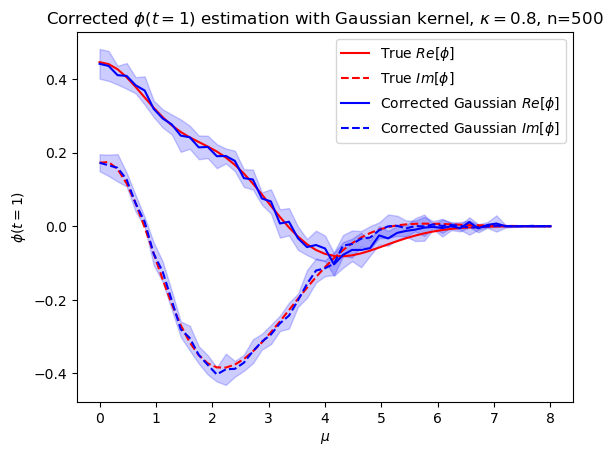

In [4]:
plt.plot(mu_list, phi1_true_list.real, color = 'red', label = 'True $Re[\phi]$')
plt.plot(mu_list, phi1_true_list.imag, color = 'red', linestyle = '--', label = 'True $Im[\phi]$')

plt.plot(mu_list, phi1_avg_gaussian_list.real, color = 'blue', label = 'Corrected Gaussian $Re[\phi]$')
plt.plot(mu_list, phi1_avg_gaussian_list.imag, color = 'blue', linestyle = '--', label = 'Corrected Gaussian $Im[\phi]$')
plt.fill_between(mu_list, phi1_avg_gaussian_list.real - phi1_std_real_gaussian_list, phi1_avg_gaussian_list.real + phi1_std_real_gaussian_list, color = 'blue', alpha = 0.2)
plt.fill_between(mu_list, phi1_avg_gaussian_list.imag - phi1_std_imag_gaussian_list, phi1_avg_gaussian_list.imag + phi1_std_imag_gaussian_list, color = 'blue', alpha = 0.2)

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\phi(t=1)$')
plt.title(r'Corrected $\phi(t=1)$ estimation with Gaussian kernel, $\kappa=$' + str(kappa) + ', n=' + str(n))
plt.legend()


print("Average MSE of Gaussian kernel for phi(1): ", avg_error, " +/- ", std_error)
print("Average bandwidth of Gaussian kernel for phi(1): ", avg_bd, " +/- ", std_bd)